This project is from kaggle at this [Link](https://www.kaggle.com/datasets/meirnizri/covid19-dataset)

Read the data from raw_date folder

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import os

from library.sb_utils import save_file


df = pd.read_csv('../raw_data/CovidData.csv')

df.head()


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


Check for missing values

In [3]:
df.isna().any()

USMER                   False
MEDICAL_UNIT            False
SEX                     False
PATIENT_TYPE            False
DATE_DIED               False
INTUBED                 False
PNEUMONIA               False
AGE                     False
PREGNANT                False
DIABETES                False
COPD                    False
ASTHMA                  False
INMSUPR                 False
HIPERTENSION            False
OTHER_DISEASE           False
CARDIOVASCULAR          False
OBESITY                 False
RENAL_CHRONIC           False
TOBACCO                 False
CLASIFFICATION_FINAL    False
ICU                     False
dtype: bool

Plot histogram to look at each feature

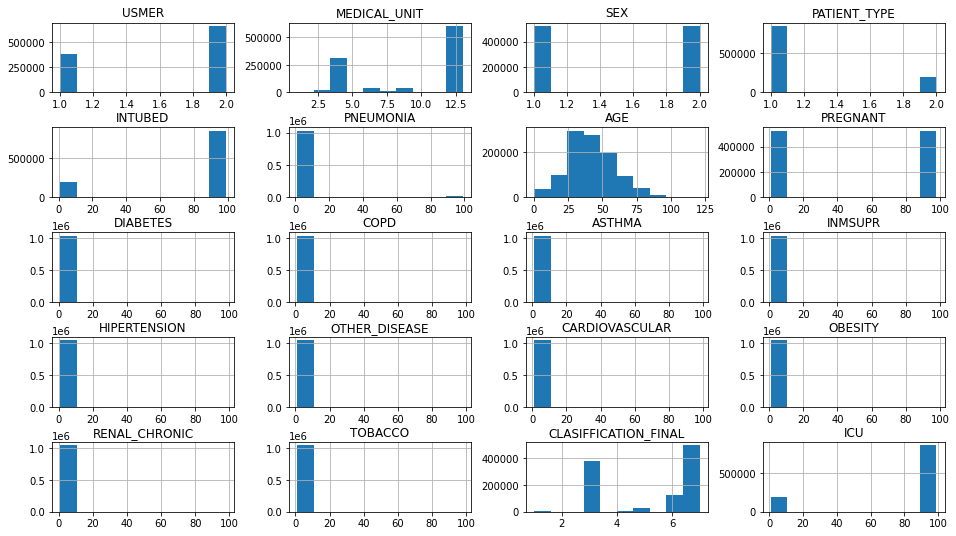

In [4]:
df.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

In this data set, values 97,98, and 99 are missing values. Looking at the histograms and considering possible values for each feature, it is noticed that the following features have most likely missign values:

* Intubed (Whether the patient was connected to the ventilator or not) 
* ICU for the same reason
* Pneumonia (whether the patient already have air sacs inflammation or not)

In [5]:
# df['INTUBED'].value_counts()
df[['ICU','INTUBED','PATIENT_TYPE']].value_counts()

ICU  INTUBED  PATIENT_TYPE
97   97       1               848544
2    2        2               151387
     1        2                24296
1    1        2                 9306
     2        2                 7552
99   99       2                 7323
     2        2                  111
     1        2                   54
2    99       2                    2
Name: count, dtype: int64

In [6]:
df[df['INTUBED'].isin([97,99])][['INTUBED','PATIENT_TYPE']].groupby('INTUBED').count()

,PATIENT_TYPE
INTUBED,
97,848544
99,7325


Patients who went home have missing values for INTUBED and ICU which make sense. So we can simply replace those with number 2 meaning "No". 

In [7]:
df.loc[(df.PATIENT_TYPE==1) & (df.INTUBED==97),'INTUBED'] = 2
df.loc[(df.PATIENT_TYPE==1) & (df.ICU==97),'ICU'] = 2

In [8]:
df[['ICU','INTUBED']].value_counts()

ICU  INTUBED
2    2          999931
     1           24296
1    1            9306
     2            7552
99   99           7323
     2             111
     1              54
2    99              2
Name: count, dtype: int64

There are 7490 patient records that were hospitalized with missing values for one or both of the ICU and INTUBED features. These records should be dropped from the data set as there is no way to validate.  

In [9]:
df[(df.ICU == 99) | (df.INTUBED == 99)].shape

(7490, 21)

In [10]:
df.drop(df[(df.ICU == 99) | (df.INTUBED == 99)].index, inplace =True)

In [11]:
df[['ICU','INTUBED']].value_counts()

ICU  INTUBED
2    2          999931
     1           24296
1    1            9306
     2            7552
Name: count, dtype: int64

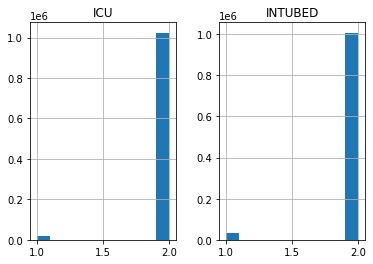

In [12]:
df[['ICU','INTUBED']].hist()
plt.show()

Death date column can be used to create the target labels. 

* Assumption: Any patient with a past DATE_DIED is dead and the rest are alive.  

In [13]:
df['DATE_DIED']

0          03/05/2020
1          03/06/2020
2          09/06/2020
3          12/06/2020
4          21/06/2020
              ...    
1048570    9999-99-99
1048571    9999-99-99
1048572    9999-99-99
1048573    9999-99-99
1048574    9999-99-99
Name: DATE_DIED, Length: 1041085, dtype: object

The type of the data in this column is string. The values "9999-99-99" must be replaced by an empty string.

Create a new column seperating dead and alive patients by comparing their DATE_DIED with today's date

In [14]:
df.loc[df.DATE_DIED=='9999-99-99','DATE_DIED']=''

df['DATE_DIED'] = pd.to_datetime(df['DATE_DIED'], format='%d/%m/%Y', errors='coerce')

today = dt.datetime.today().date()

df['DIED'] = 2
df.loc[df.DATE_DIED <= pd.Timestamp(today),'DIED'] = 1

df.drop(columns = ['DATE_DIED'], inplace = True)

Create a binary feature for COVID result (1 shows positive result and 2 means negative) based on the test classification and drop CLASSIFICATION_FINAL column

In [15]:
df['COVID'] = np.where(df.CLASIFFICATION_FINAL.isin([1,2,3]),1,2)

df.drop(columns=['CLASIFFICATION_FINAL'], inplace = True)

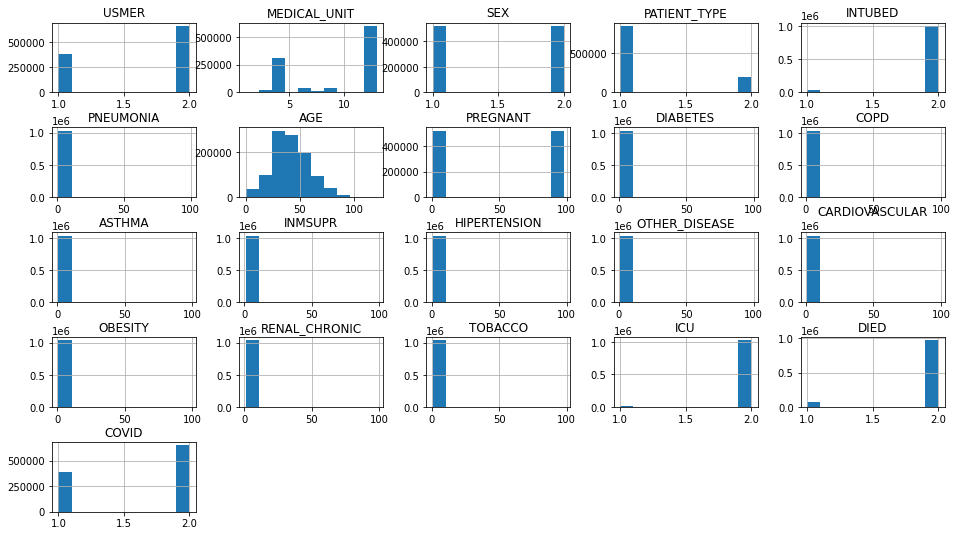

In [16]:
df.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

The value 1 for SEX means female and 2 means male. 

In [17]:
df[['PREGNANT','SEX']].value_counts()

PREGNANT  SEX
97        2      519572
2         1      509957
1         1        7962
98        1        3594
Name: count, dtype: int64

There is no male patient with a yes for pregnant feature. All the 97's belong to male patients meaning that they are not pregnant. The PREGNANT feature for these records can definitely be replaced with 2 meaning 'No'. 

In [18]:
df.loc[df.PREGNANT.isin([97]),'PREGNANT'] = 2

However, the missing value 98's belong to only female patients (3594) which might be pregnant or not but the data was missing for some reason. Before dropping them, let's look at the distribution of these patients over the age. Assuming no pregnancy can happen after the age of 50, we can simply replace those 98's for pregnancy by 2 meaning "No".

In [19]:
df.loc[(df.PREGNANT.isin([98])) & (df.AGE>=50),'PREGNANT'] = 2

The remaing records with 98 for the pregnancy will be dropped. 

In [20]:
df.drop(df[df.PREGNANT==98].index, inplace = True)

In [21]:
df[['PREGNANT','SEX']].value_counts()

PREGNANT  SEX
2         2      519572
          1      510830
1         1        7962
Name: count, dtype: int64

In [22]:
df['PNEUMONIA'].value_counts()

PNEUMONIA
2     888761
1     138913
99     10690
Name: count, dtype: int64

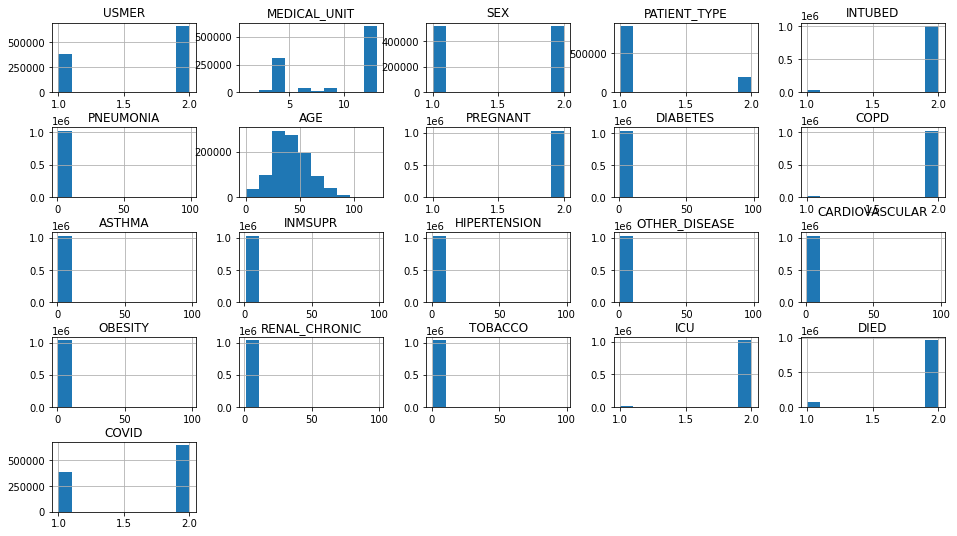

In [23]:
df[df['COPD']<90].hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

There are no information on other diseases. Considering the fact that there are 4792 patients with that information missing, this column will be dropped as there are no useful information or conclusion that can be extracted in relevant to the target feature. 

In [24]:
df.loc[df['OTHER_DISEASE']>90].shape

(4792, 21)

In [25]:
df.drop(columns = ['OTHER_DISEASE'], inplace = True)

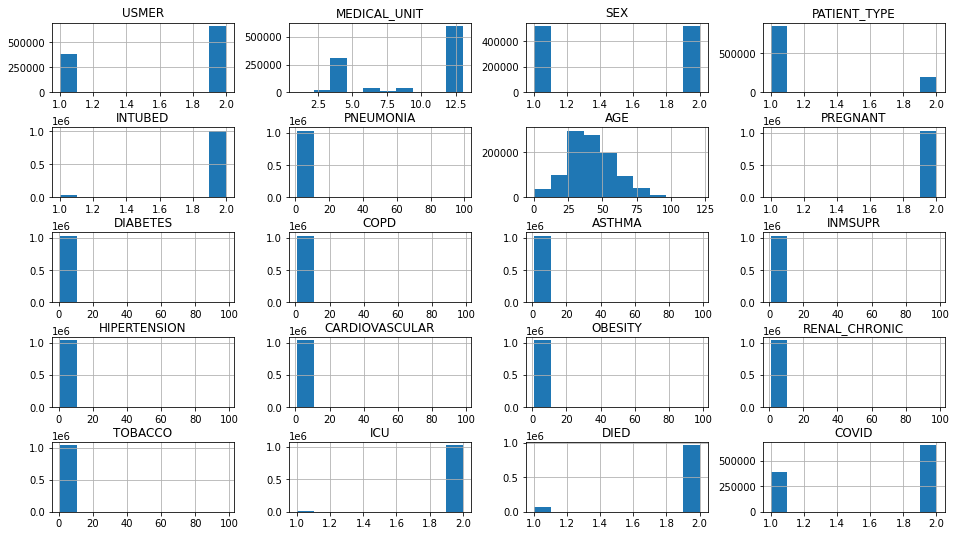

In [26]:
df.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

In [27]:
df[(df['OBESITY']>90) | (df['DIABETES']>90) | 
   (df['PNEUMONIA']>90) | (df['COPD']>90) | 
   (df['ASTHMA']>90) | (df['INMSUPR']>90) | 
   (df['HIPERTENSION']>90) | (df['CARDIOVASCULAR']>90) |
   (df['RENAL_CHRONIC']>90) | (df['TOBACCO']>90)].shape[0]/df.shape[0]* 100

1.5639024465409046

Any missing values on the diseases are dropped as there is no way to impute those missing numbers. They are 1.56% of the total dataset so they can be dropped.

In [28]:
df.drop(df[(df['OBESITY']>90) | (df['DIABETES']>90) | 
   (df['PNEUMONIA']>90) | (df['COPD']>90) | 
   (df['ASTHMA']>90) | (df['INMSUPR']>90) | 
   (df['HIPERTENSION']>90) | (df['CARDIOVASCULAR']>90) |
   (df['RENAL_CHRONIC']>90) | (df['TOBACCO']>90)].index, inplace = True)

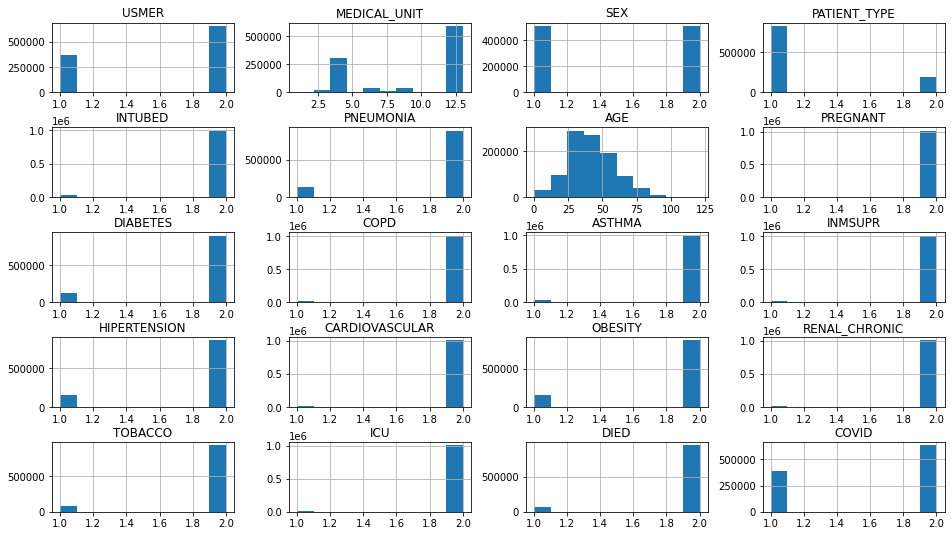

In [29]:
df.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

Let's look at the distribution of pregnannt feature over the age 

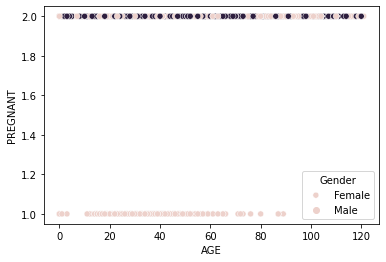

In [30]:
sns.scatterplot(data = df, x='AGE', y='PREGNANT', hue = 'SEX')
plt.legend(title = 'Gender', labels=['Female','Male'])
plt.show();

This still shows that there are some women with positive pregnancy above the age of 50. Those can be replaced by value 2 in their PREGNANT  feature.

In [31]:
df.loc[(df.PREGNANT==1) & (df.AGE > 50), 'PREGNANT'] = 2

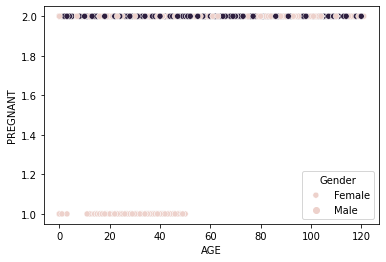

In [32]:
sns.scatterplot(data = df, x='AGE', y='PREGNANT', hue = 'SEX')
plt.legend(title = 'Gender', labels=['Female','Male'])
plt.show();

There is one last thing that looks suspicious but there is no way to check if they are errors or correct. There are some observations in AGE column with values 97, 98, and 99 but we assume those are correct ages of the patients. 

In [33]:
df[df.AGE.isin([97,98,99])].shape

(322, 20)

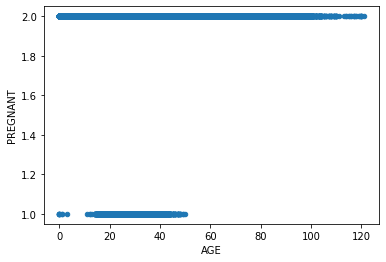

In [34]:
df.plot(x= 'AGE', y='PREGNANT', kind='scatter')

plt.show();

In [35]:
df[(df.PREGNANT==1) & (df.AGE < 15)]['AGE'].sort_values()

15776       0
422568      0
422625      0
960265      0
682740      0
1048103     1
668330      1
800057      3
957627     11
695902     12
928395     12
851116     13
687274     14
704916     14
729133     14
1007395    14
819644     14
823134     14
863284     14
569692     14
1005788    14
742419     14
Name: AGE, dtype: int64

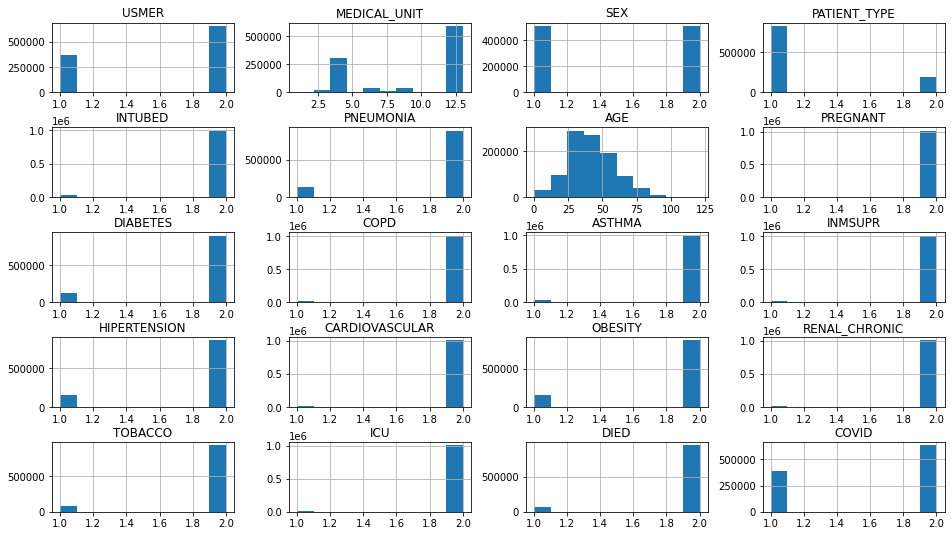

In [36]:
df.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5)
plt.show()

Save a new file with th eclean data

In [37]:
datapath = '../data'
save_file(df, 'data_cleaned.csv', datapath)

A file already exists with this name.

Writing file.  "../data\data_cleaned.csv"
